# Como lake: Daily dataset exploration
The dataset provided by the researchers of PoliMi contains the daily *Levels* (in $cm$), *Inflows* (in $m^3/s$) and *Releases* (in $m^3/s$) of the Como lake from 1946 to 2011. More recent values can be found at this [link](https://adda.laghi.net/homepage.aspx?tab=3&subtab=2&idlago=1). This notebook will be used to explore the dataset and to study the process that produces the inflows values.

Let's start by importing the libraries that will be used and the dataset, we will also add a new column containing the complete datetime of each entry:

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os

from fbprophet import Prophet
import fbprophet.plot as fbp
from statsmodels.graphics import tsaplots
import scipy.stats 

# Import the dataset 
df = pd.read_csv('data/como_data_1946_2011.txt', sep="  ", engine='python')
df['date'] = pd.to_datetime(df[["year", "month", "day"]])
df

,day,month,year,level,release,inflow,date
0,1.0,1.0,1946.0,1.150,116.00,65.6,1946-01-01
1,2.0,1.0,1946.0,1.120,93.00,93.0,1946-01-02
2,3.0,1.0,1946.0,1.120,84.00,67.2,1946-01-03
3,4.0,1.0,1946.0,1.110,84.00,33.6,1946-01-04
4,5.0,1.0,1946.0,1.080,84.00,84.0,1946-01-05
...,...,...,...,...,...,...,...
23979,27.0,8.0,2011.0,0.355,196.21,204.6,2011-08-27
23980,28.0,8.0,2011.0,0.360,194.42,102.1,2011-08-28
23981,29.0,8.0,2011.0,0.305,194.19,160.6,2011-08-29
23982,30.0,8.0,2011.0,0.285,189.73,72.3,2011-08-30


# Inflow modelling
Let's start by plotting a portion of the inflow time series. We will take a look at one of the last available years to check that the data is the same than the one available online [here](https://adda.laghi.net/homepage.aspx?tab=3&subtab=2&idlago=1).

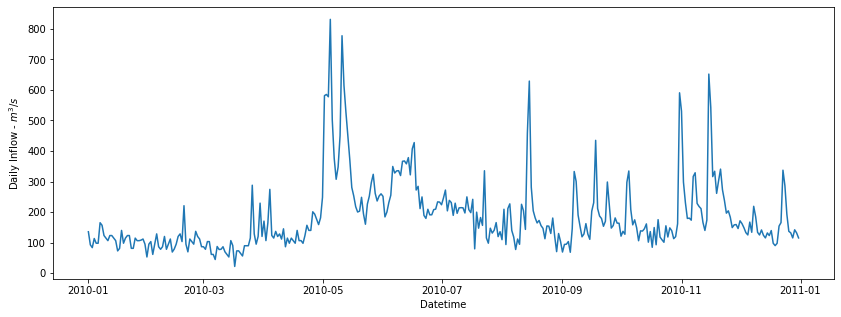

In [37]:
# Plot sequence of inflows of the last full year
plt.figure(figsize=(14,5))
plt.plot(df.date[df.year==2010], df.inflow[df.year==2010])
plt.xlabel('Datetime')
plt.ylabel('Daily Inflow - '+r'$m^3/s$')
plt.show()

## Seasonality 
We already know that there is seasonality, we will repeat the seasonal decomposition of the weekly analysis to obtain the seasonal component using the Prophet libary. Differently from the other analysis, here we also have many more years, thus we will also study the non stationary behavior that the trend will present.

To be more specific, here the library will model the time series by extracting a periodic seasonal component, represented by a Fourier series (by trial and error, the best number of harmonics seems to be `yearly_seasonality = 8`), and using a piecewise linear function (with `n_changepoints` that will be evaluated and accepted with a sensibility that depends on `changepoint_prior_scale`) to model the trend within years.

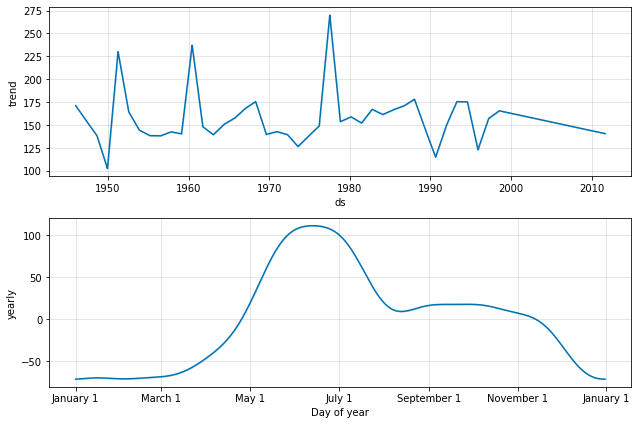

In [81]:
# THIS MAY TAKE FEW MINUTES

# format data to be compatible with the library
inflow = df[['date','inflow']]
inflow.columns = ['ds','y']

# Find seasonality (fit it using fourier series of given order)
model = Prophet(yearly_seasonality = 8, 
                weekly_seasonality = False,
                daily_seasonality  = False,
                n_changepoints = 40,
                changepoint_prior_scale=0.5)
model.fit(inflow)

# Build estimated inflows
inflow_estim = model.predict()

# Plot fitted components
model.plot_components(inflow_estim)
plt.show()

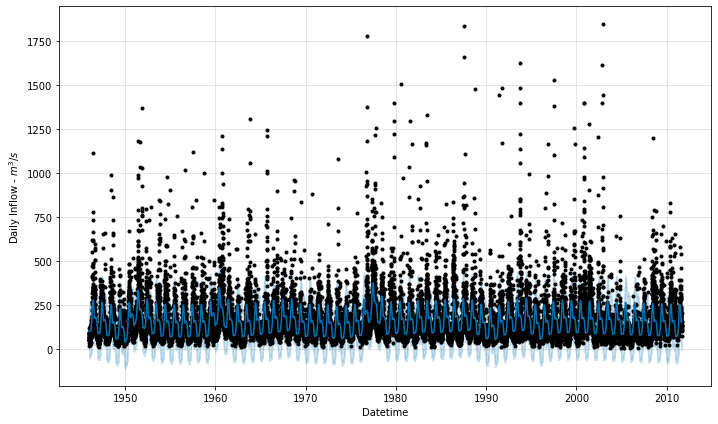

In [82]:
# Plot (few years of) the estimated inflow
model.plot(inflow_estim)
plt.xlabel('Datetime')
plt.ylabel('Daily Inflow - '+r'$m^3/s$')
#plt.xlim((0,2000))
#plt.ylim(-100,800)
plt.show()

Another easy way to obtain the trend is to just have one point for each year, averaging all the inflows within it -> Still a piecewise linear function

A more smoother trend could be obtained subtracting the seasonal components and then filtering the inflow values with a moving average (or with another filter that averages out the noise, smoothing the signal). 

In [77]:
# COMPUTE SMOOTHER TREND IF NEEDED

## Correlation between subsequent values

So, let's see if subsequent values are indeed correlated. I would consider them correlated if, after removing the trend and the seasonal component, the inflow value at any point in time is somewhat similar to the preceeding one. It is not sufficient to prove that the original inflow values are correlated because it may be due to the smooth evolution of the trend of the seasonality component, thus giving "just" a time-dependent distribuition of the form $p_t(x)$ (where $x$ is the inflow). If, otherwise, the values are correlated after removing such temporal components, then the inflows could be modelled with a time-dependent distribution that depends also on the previous value, like $p_t(x_t|x_{t-1})$.

I will plot the histogram of the differences between subsequent values of the inflows (after removing trend and seasonal component) and, to be sure that these values are actually correlated, the auto-correlation plot.

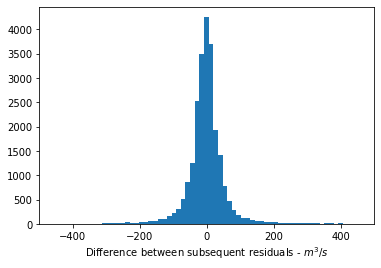

In [78]:
"""
# Plot histogram of differences between subsequent values
plt.hist(inflow.y[1:].values - inflow.y[:-1].values, bins=150)
plt.xlabel('Difference between subsequent inflows - '+r'$m^3/s$')
plt.xlim((-500,500))
plt.show()
"""

# Compute residuals and the diffenence between subsequent values
residuals = inflow.y - inflow_estim.yhat
delta_residuals = residuals[1:].values - residuals[:-1].values

# Plot histogram of differences between subsequent residuals
plt.hist(delta_residuals, bins=150)
plt.xlabel('Difference between subsequent residuals - '+r'$m^3/s$')
plt.xlim((-500,500))
plt.show()

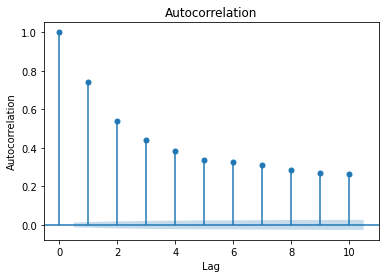

In [84]:
# Display the autocorrelation plot of the inflow 
# values after removing seasonal component 
fig = tsaplots.plot_acf(residuals, lags=10)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag')
plt.show()

It is possible to see from this last plot that subsequent values are higly correlated, thus it makes sense having a distribution of the form  $p_t(x_t|x_{t-1})$. Moreover, The differences between consecutive inflows follow a gaussian distribution centered on the previous values (is this reliable?).

How should the distribution $p_t(x_t|x_{t-1})$ be constructed? Ideas:
 - For each day in the year, find parameters $\mu_\tau, \sigma_\tau$ (with $\tau\in[1, 365]$) such that the inflow is sampled from the gaussian with $\mu_t = x_{t-1}+\mu_\tau$ and $\sigma_t=\sigma_\tau$. In particular, each distribution is fitted using the residual of that specific day from each year. This approach leads to wrong distribution when $x_{t-1}$ is an "outlier".